In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from rep.estimators import TMVAClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
#from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import random
from copy import deepcopy
import cPickle as pickle


In [13]:
my_clfs = {}
my_clfs['TMVA kMLP'] = TMVAClassifier(method='kMLP',
                      #features=features,
                      factory_options="V:!Silent:!Color:!DrawProgressBar",
                      H='true',
                      V='true',
                      EpochMonitoring='true',
                      #HiddenLayers=int(1.2*len(features)),
                      UseRegulator='true',
                      ConvergenceImprove = "1e-16",
                      ConvergenceTests = "15",
                      VarTransform = "Norm",
                      NCycles = 750,
                      NeuronType = "sigmoid",
                      TrainingMethod = "BP",
                      EstimatorType = "CE")

my_clfs['TMVA kBDT'] = TMVAClassifier(method='kBDT',
                      #features=features,
                      factory_options="V:!Silent:!Color:!DrawProgressBar",
                      H='false',
                      V='true',
                      NTrees=800,
                      VarTransform = "Norm",
                      BoostType = "AdaBoost",
                      PruneMethod = "CostComplexity",
                      PruneStrength = -1,
                      MaxDepth = 3,
                      PruningValFraction = 0.3)

In [30]:
sample = 0.1

def load_data(track = 'long', 
              data_path = 'data/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/\
GhostAccFrac1.0/TMVA-Run2-NoTkLikCD/',
              data_filename = 'data_train.csv', 
              
              sample=sample, seed = 0):
    
    
    
    #particle = particle[0].upper() + particle[1:].lower()
    track = track[0].upper() + track[1:].lower()
    
    cur_file_path = data_path + '/' + track + '/' + data_filename
    
    if sample:
        n = sum(1 for line in open(cur_file_path)) - 1
        s = int(n*sample)
        skip = sorted(random.sample(range(1,n+1),n-s))
    else:
        skip = None

    cur_data = pd.read_csv(cur_file_path, skiprows=skip)
    
    #data['TrackCloneDist'] *= 1 + 0.00001 * np.random.rand(len(data))
    
    
    return cur_data

def get_target(particle, loc_data, 
            code_dict = {"all": 999999,
                    "Ghost": 0,
                    "Electron": 11,
                    "Muon": 13,
                    "Pion": 211,
                    "Kaon": 321,
                    "Proton": 2212}):
    
    particle = particle[0].upper() + particle[1:].lower()
    target = (np.abs(loc_data.MCParticleType.values) == code_dict[particle]) * 1
    return target

def load_features(particle, track='long',
                  config_path = 'data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/',
                  prefix = 'GlobalPID',
                  suffix = 'ANN.txt'):

    particle = particle[0].upper() + particle[1:].lower()
    track = track[0].upper() + track[1:].lower()
    cur_config_path = '_'.join([config_path + prefix, particle, track, suffix])
    cur_config = np.loadtxt(cur_config_path, dtype='S', delimiter='\n', comments='!')
    features = [item for item in cur_config[5:] if '#' not in item]
    return features 

In [31]:
particles = ['electron', 'pion', 'kaon', 'muon', 'ghost', 'proton']

train_data = load_data(data_filename='data_train.csv')
test_data = load_data(data_filename='data_eval.csv')
features_dict = dict.fromkeys(particles)
train_target_dict = dict.fromkeys(particles)
test_target_dict = dict.fromkeys(particles)
bdt_dict = dict.fromkeys(particles)
mlp_dict = dict.fromkeys(particles)

In [37]:
for key in particles:
    features_dict[key] = load_features(key)  
    train_target_dict[key] = get_target(key, train_data)
    test_target_dict[key] = get_target(key, test_data)
    my_clfs['TMVA kBDT'].set_params(**{'features' : features_dict[key]})
    bdt_dict[key] = deepcopy(my_clfs['TMVA kBDT'])
    
    my_clfs['TMVA kMLP'].set_params(**{'features' : features_dict[key],
                                       'HiddenLayers' : int(1.2*len(features_dict[key]))})
    mlp_dict[key] = deepcopy(my_clfs['TMVA kMLP'])
    

In [34]:
def compare_rocs(particles, clfs, 
                 train, test, 
                 train_targets, test_targets, 
                 features,
                 dump = False,
                 dump_folder = 'models/',
                model_prefix = None,
                model_suffix = None):

    colors = plt.cm.rainbow(np.linspace(0,1,len(particles)))
    color_dict = {}
    for key, color in zip(particles, colors):
        color_dict[key] = color 
    plt.figure(figsize=(8,8))
    for key in particles:
        cur_clf = clfs[key]
        cur_train_target = train_targets[key]
        cur_test_target = test_targets[key]
        cur_features = features[key]

        cur_clf.fit(train[cur_features], cur_train_target)
        probs = cur_clf.predict_proba(test[cur_features])
        auc = roc_auc_score(cur_test_target, probs[:, 1])
        print(auc)
        fpr, tpr, _ = roc_curve(cur_test_target, probs[:, 1])
        #cur_results['ROC_curve'] = fpr, tpr
        plt.plot(fpr, tpr, color=color_dict[key], label = key + " AUC = %.3f" % auc)
        if dump:
            with open(dump_folder + model_prefix + '_' + key+'_classifier.pkl', 'wb') as f:
                pickle.dump(cur_clf, f)

    plt.legend(loc=4)
    plt.show()    

0.972081313983
0.936466025248
0.927782205204
0.985770049241
0.957467242056
0.909246945958


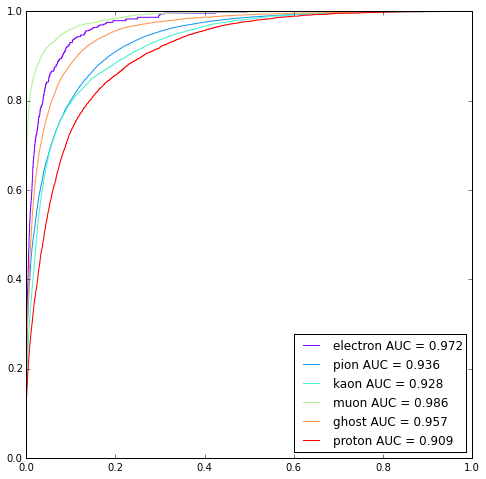

In [35]:
compare_rocs(particles = particles, clfs = bdt_dict,
            train = train_data, test = test_data, 
            train_targets = train_target_dict, test_targets = test_target_dict, 
            features = features_dict,
            dump = True,
            model_prefix = 'TMVA_kBDT')

0.910301276008
0.934550351195
0.926881170141
0.975273576459
0.954485567412
0.913488737473


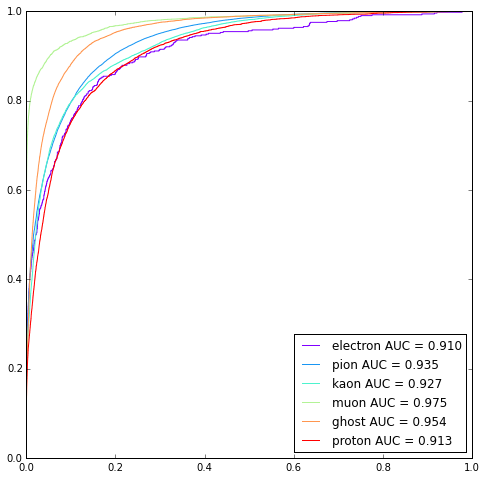

In [39]:
compare_rocs(particles = particles, clfs = mlp_dict,
            train = train_data, test = test_data, 
            train_targets = train_target_dict, test_targets = test_target_dict, 
            features = features_dict,
            dump = True,
            model_prefix = 'TMVA_kMLP')